In [10]:
!pip install --force-reinstall llama-index==0.11.3 llama-index-llms-groq==0.2.0

  Using cached llama_index_indices_managed_llama_cloud-0.6.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached llama_index_legacy-0.9.48.post4-py3-none-any.whl.metadata (8.5 kB)
  Using cached llama_index_readers_llama_parse-0.4.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached dirtyjson-1.0.8-py3-none-any.whl.metadata (11 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 11.2 MB/s eta 0:00:00
  Using cached tenacity-8.5.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tiktoken-0.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.8 MB/s eta 0:00:00
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached llama_cloud-0.1.6-py3-none-

Useful resources

[What is LLM observability?](https://truera.com/ai-quality-education/generative-ai-observability/what-is-llm-observability/)

[Evaluating Gen AI - RAGs](https://truera.com/ai-quality-education/generative-ai-rags/what-is-the-rag-triad/)

RAG Triad: https://truera.com/wp-content/uploads/2024/03/TruEra-The-Rag-Triad-1-1024x634.png

### **LLM Observability**

This recent progress of LLM applications is remarkable in many aspects, but they also create unique risks such as hallucinations, toxicity and bias.

LLM observability plays a crucial role in mitigating these risks through systematic tracking, evaluation and monitoring of LLM applications in development and in live use.

#### **Honest, Harmless and Helpful Evaluations**

TruLens's suite of evaluations: https://truera.com/wp-content/uploads/2024/02/TruEra-LLM-Observability-FIgure-2-1024x387.jpg

  * **Honest**: Fundamentally, an LLM app should give accurate information to end users. To this end, it should have access too, retrieve and reliably use the information needed to answer questions it is intended for.

  * **Harmless**: An LLM app should not produce dangerous, offensive or discriminatory outputs. For instance, when asked to aid in a dangerous act (e.g. building a bomb), the AI should politely decline.

  * **Helpful**:An LLM app should be purposely designed to perform a designated task or answer a specific question posed (as long as this isn’t harmful) to the best of its abilities.
  
  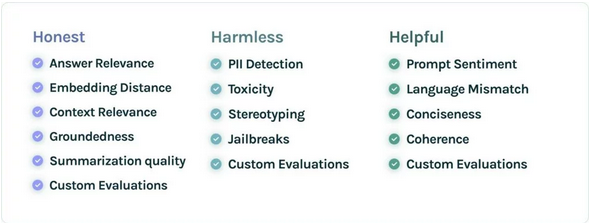

### Evaluating RAG applications

 RAGs don’t fully eliminate the risk of hallucinations for various reasons.
 * The retrieval could simply fail to retrieve sufficient context or retrieve irrelevant context.
 * They may suffer from a lack of groundness. This means that the response generated by a RAG app is not supported by the retrieved context, but is mostly influenced by the LLM and its training data.
 * A RAG app may retrieve relevant pieces of context, then leverage them to produce a grounded response and yet still fail to address a user query.

#### **The RAG Triad**

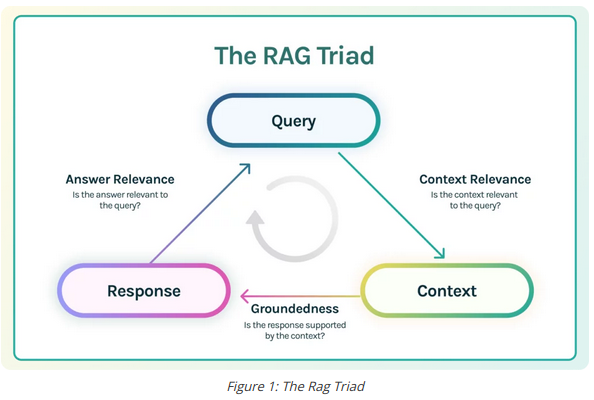

The RAG triad is composed of three evaluations: context relevance, groundedness and answer relevance. If an LLM app scores high on all of them, we can confidently assert that it is free from hallucination. Let’s review them in order.

  * **Context Relevance**: Retrieval is the initial step in any RAG application. In order to check the quality of our retrieval, we want to make sure that each piece of context is relevant to the input query. This is crucial because this context will be used by the LLM to produce an answer and thus any irrelevant information in the context could be weaved into a hallucination.

  * **Groundedness**: Once the context is retrieved, the LLM produces an answer. LLMs have a tendency to exaggerate, distort, or make up facts that sound correct but are not. To mitigate this risk, we divide the response into distinct claims and independently search for evidence that supports each within the retrieved context. Groundedness measures the extent to which the claims made by the LLM can be attributed back to source text.

  * **Answer Relevance**: Finally, the original question must still be helpfully answered by our response. We can confirm this by evaluating the relevance of the final response to the user input.

#### RAG Framework

In [2]:
# !pip install -q -U llama-index llama-index-llms-groq llama-index-embeddings-huggingface llama-index-readers-web

In [3]:
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

from llama_index.core.llms import ChatMessage
from llama_index.llms.groq import Groq

In [4]:
from llama_index.readers.web import SimpleWebPageReader

from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.schema import TextNode

from llama_index.embeddings.huggingface import HuggingFaceEmbedding

from tqdm import tqdm

from llama_index.core import VectorStoreIndex

from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core import get_response_synthesizer

from llama_index.core import PromptTemplate

In [5]:
# RAG framework

# Create LLM object
llm = Groq(model="llama3-70b-8192", api_key=GROQ_API_KEY)

# Load data
web_reader_obj = SimpleWebPageReader(html_to_text=True,)
documents = web_reader_obj.load_data(
    urls = ["https://indianexpress.com/section/political-pulse/",
            "https://indianexpress.com/section/technology/",
            "https://indianexpress.com/section/entertainment/"])

# text splitter
text_parser = TokenTextSplitter(
    chunk_size=512,
    chunk_overlap=50
)
chunks = text_parser.split_text(text=documents[0].text)

# load the embedding model from hugging face
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

# convert chunks into llama nodes
nodes = [TextNode(text=chunk_text) for chunk_text in chunks]

# Create embeddings for the chunks
for node in tqdm(nodes):
    node.embedding = embed_model.get_text_embedding(
        node.get_content(metadata_mode="all")
    )

100%|██████████| 40/40 [01:16<00:00,  1.92s/it]


In [6]:
# index the data
index = VectorStoreIndex(
    nodes=nodes, embed_model=embed_model
)

# Create a retriever object
retriever = index.as_retriever(similarity_top_k=3)


# Create prompt
template = (
        "You are an expert in answering questions related to current affairs."
        "Context information is below which is extracted from news websites.\n"
        "---------------------\n"
        "{context_str}\n"
        "---------------------\n"
        "Given the context information and not prior knowledge, answer the question asked by the user."
        "Include useful URLs in the response."
        "answer the query.\n"
        "Query: {query_str}\n"
        "Answer: "
)
qa_template = PromptTemplate(template)

# configure response synthesizer
response_synthesizer = get_response_synthesizer(llm, text_qa_template = qa_template)


# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.3)]
)

In [9]:
# query
query_response = query_engine.query("How much is pushpa 2 predicted to make")
print(query_response)

According to the article "[Pushpa 2 box office collection Day 3: Allu Arjun juggernaut becomes fastest film to breach Rs 500 crore club](https://indianexpress.com/article/entertainment/telugu/pushpa-2-box-office-collection-day-3-allu-arjun-juggernaut-becomes-fastest-film-to-breach-rs-500-crore-club-9712723/)", Pushpa 2 has already breached the Rs 500 crore club in just 3 days. The article does not provide a specific prediction for the total amount it is expected to make, but it's clear that it's off to a phenomenal start.


#### Build RAG Traid from scratch

The below prompts are from trulens, you can checkout more prompts and evavluation criteria at https://github.com/truera/trulens/blob/main/src/feedback/trulens/feedback/v2/feedback.py

In [22]:
LIKERT_0_10_PROMPT: str = "0 to 10, where 0 is the lowest score according to the criteria and 10 is the highest possible score"
LIKERT_0_10_MIN: str = "0"
LIKERT_0_10_MAX: str = "10"


# Groundedness

class Groundedness:

  system_prompt = f"""You are an INFORMATION OVERLAP classifier; providing the overlap of information (entailment or groundedness) between the source and statement.
  Respond only as a number from {LIKERT_0_10_PROMPT}.

  You should score the groundedness of the statement based on the following criteria:
  - Statements that are directly supported by the source should be considered grounded and should get a high score.
  - Statements that are not directly supported by the source should be considered not grounded and should get a low score.
  - Statements of doubt, that admissions of uncertainty or not knowing the answer are considered abstention, and should be counted as the most overlap and therefore get a max score of {LIKERT_0_10_MAX}.

  Never elaborate."""


  user_prompt = """SOURCE: {premise}

  Hypothesis: {hypothesis}

  Please meticulously answer with the template below for ALL statement sentences:

  Criteria: <Statement Sentence>
  Supporting Evidence: <Identify and describe the location in the source where the information matches the statement. Provide a detailed, human-readable summary indicating the path or key details. if nothing matches, say NOTHING FOUND. For the case where the statement is an abstention, say ABSTENTION>
  Score: <Output a number based on the scoring output space / range>
  """

# Context relevance
class ContextRelevance:
  system_prompt = f"""You are a RELEVANCE grader; providing the relevance of the given CONTEXT to the given QUESTION.
  Respond only as a number from {LIKERT_0_10_PROMPT}.

  Criteria for evaluating relevance:
  - CONTEXT that is IRRELEVANT to the QUESTION should score {LIKERT_0_10_MIN}.
  - CONTEXT that is RELEVANT to some of the QUESTION should get an intermediate score.
  - CONTEXT that is RELEVANT to most of the QUESTION should get a score closer to {LIKERT_0_10_MAX}.
  - CONTEXT that is RELEVANT to the entirety of the QUESTION should get a score of {LIKERT_0_10_MAX}, which is the full mark.
  - CONTEXT must be relevant and helpful for answering the entire QUESTION to get a score of {LIKERT_0_10_MAX}.


  A few additional scoring guidelines:

  - Long CONTEXTS should score equally well as short CONTEXTS.

  - RELEVANCE score should increase as the CONTEXTS provides more RELEVANT context to the QUESTION.

  - RELEVANCE score should increase as the CONTEXTS provides RELEVANT context to more parts of the QUESTION.

  - Never elaborate.
  """

  user_prompt = """QUESTION: {question}
  CONTEXT: {context}

  RELEVANCE:
  """

# Answer Relevance
class AnswerRelevance:
  system_prompt = f"""You are a RELEVANCE grader; providing the relevance of the given RESPONSE to the given PROMPT.
  Respond only as a number from {LIKERT_0_10_PROMPT}.

  A few additional scoring guidelines:

  - Long RESPONSES should score equally well as short RESPONSES.

  - RESPONSE must be relevant to the entire PROMPT to get a maximum score of {LIKERT_0_10_MAX}.
  - RELEVANCE score should increase as the RESPONSE provides RELEVANT context to more parts of the PROMPT.
  - RESPONSE that is RELEVANT to none of the PROMPT should get a minimum score of {LIKERT_0_10_MIN}.
  - RESPONSE that is RELEVANT and answers the entire PROMPT completely should get a score of {LIKERT_0_10_MAX}.
  - RESPONSE that confidently FALSE should get a score of {LIKERT_0_10_MIN}.
  - RESPONSE that is only seemingly RELEVANT should get a score close to {LIKERT_0_10_MIN}.
  - Answers that intentionally do not answer the question, such as 'I don't know' and model refusals, should also be counted as the least RELEVANT and get a score of {LIKERT_0_10_MIN}.

  - Never elaborate.
  """

  user_prompt = """PROMPT: {prompt}

  RESPONSE: {response}

  RELEVANCE:
  """

In [23]:
print(ContextRelevance.user_prompt)

QUESTION: {question}
  CONTEXT: {context}

  RELEVANCE:
  


In [24]:
llm = Groq(model="llama3-70b-8192", api_key=GROQ_API_KEY)

In [25]:
def get_response_from_llm(system_prompt, user_prompt):
  messages = [
      ChatMessage(
          role="system", content=system_prompt
      ),
      ChatMessage(role="user", content=user_prompt),
  ]
  resp = llm.chat(messages)

  return resp.message.content

In [26]:
get_response_from_llm("aswer in emoji only", "Hi")

'👋'

Evaluate the RAG response on all three categories:

- Context relevance
- Groundedness
- Answer relevance

In [27]:
def get_context_relevance(query, response, context):

  system_prompt = ContextRelevance.system_prompt
  user_prompt = ContextRelevance.user_prompt.format(question=query, context=context)

  return get_response_from_llm(system_prompt, user_prompt)

def get_groundedness(query, response, context):

  system_prompt = Groundedness.system_prompt
  user_prompt = Groundedness.user_prompt.format(premise=context, hypothesis=response)

  return get_response_from_llm(system_prompt, user_prompt)

def get_answer_relevance(query, response, context):

  system_prompt = AnswerRelevance.system_prompt
  user_prompt = AnswerRelevance.user_prompt.format(prompt=query, response=response)

  return get_response_from_llm(system_prompt, user_prompt)

def get_toxicity_score(response):
  return

def detect_PII(response):
  return

In [28]:
# query
query = "What are the latest updates on pushpa 2"

response_obj = query_engine.query(query)

response_str = response_obj.response
context = "\n".join([node.get_content() for node in response_obj.source_nodes])

print(response_str)

According to the latest updates, Pushpa 2: The Rule has been making waves at the box office. The movie has become the fastest film to breach the Rs 500 crore club in just three days of its release. [Read more about it here](https://indianexpress.com/article/entertainment/telugu/pushpa-2-box-office-collection-day-3-allu-arjun-juggernaut-becomes-fastest-film-to-breach-rs-500-crore-club-9712723/).

Additionally, the movie has received mixed reviews from critics, with some praising the performances of the lead actors, Allu Arjun and Fahadh Faasil, while others felt that the film choked under the weight of performance pressure. [Check out the movie review here](https://indianexpress.com/article/entertainment/movie-review/pushpa-2-the-rule-review-allu-arjun-fahadh-faasil-film-chokes-under-the-weight-of-performance-pressure-9706694/).

Unfortunately, the movie has also been leaked online, just hours after its release, which may affect its box office collections. [Read more about the leak here

In [29]:
context_relevance = get_context_relevance(query, response_str, context)

print(context_relevance)

8


In [30]:
groundedness = get_groundedness(query, response_str, context)

print(groundedness)

Here are the answers:

Criteria: According to the latest updates, Pushpa 2: The Rule has been making waves at the box office.
Supporting Evidence: https://indianexpress.com/article/entertainment/telugu/pushpa-2-box-office-collection-day-3-allu-arjun-juggernaut-becomes-fastest-film-to-breach-rs-500-crore-club-9712723/
Score: 10

Criteria: The movie has become the fastest film to breach the Rs 500 crore club in just three days of its release.
Supporting Evidence: https://indianexpress.com/article/entertainment/telugu/pushpa-2-box-office-collection-day-3-allu-arjun-juggernaut-becomes-fastest-film-to-breach-rs-500-crore-club-9712723/
Score: 10

Criteria: The movie has received mixed reviews from critics, with some praising the performances of the lead actors, Allu Arjun and Fahadh Faasil, while others felt that the film choked under the weight of performance pressure.
Supporting Evidence: https://indianexpress.com/article/entertainment/movie-review/pushpa-2-the-rule-review-allu-arjun-fahad

In [31]:
answer_relevance = get_answer_relevance(query, response_str, context)

print(answer_relevance)

10
